In [17]:
import os,random
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.losses import categorical_crossentropy
from keras import backend as K

from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import random, sys, keras
from keras.models import Model, Sequential
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.utils import shuffle


In [18]:
os.environ["CUDA_VISIBLE_DEVICES"]="1" #On rd010532 0 = Tesla, 1 = Quadro

In [19]:
def draw_model_on_interactive_session(model):

    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))


In [20]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


0.0 1.0
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 7840)              791840    
_________________________________________________________________
dense_8 (Dense)              (None, 3920)              30736720  
_________________________________________________________________
dense_9 (Dense)              (None, 784)               3074064   
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
Total params: 34,602,624
Trainable params: 34,602,624
Non-trainable params: 0
_________________________________________________________________


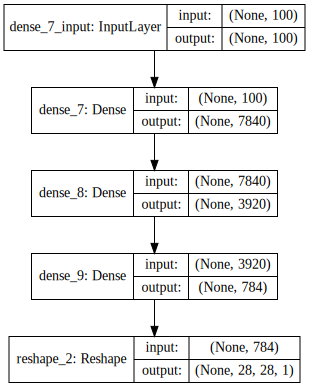

In [21]:
# Build Generative model ...
opt = Adam(lr=1e-4)

generator = Sequential(name='generator')
generator.add(Dense(28*28*10, input_shape=(100,), activation='relu'))
generator.add(Dense(28*28*5, input_shape=(100,), activation='relu'))
generator.add(Dense(28*28, activation='sigmoid'))
generator.add(Reshape((28, 28, 1)))

generator.compile(loss='mean_squared_error', optimizer=opt)
generator.summary()
draw_model_on_interactive_session(generator)

In [22]:
def initialise_generator():
    X_train[0:1000].shape
    y = np.random.uniform(0,1,size=[1000,100])

    generator.fit(y, X_train[0:1000], epochs=10, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 28, 28, 784)       1568      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        627232    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          25632     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               401664    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 1,056,610
Trainable params: 1,056,610
Non-trainable params: 0
_________________________________________________________________


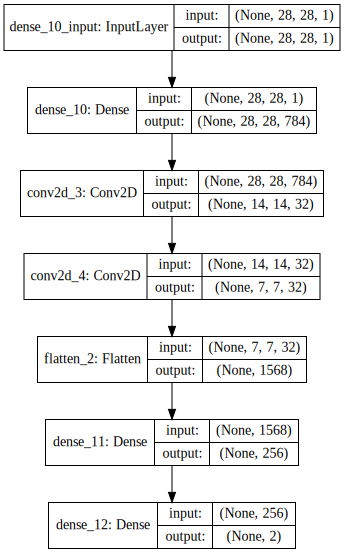

In [23]:

# Build Discriminative model ...
dopt = Adam(lr=1e-3)

discriminator = Sequential(name='discriminator')
discriminator.add(Dense(28 * 28 * 1, input_shape=(28, 28, 1)))
discriminator.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu'))
discriminator.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', activation='relu'))
discriminator.add(Flatten())
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dense(2, activation='linear'))
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
#discriminator.compile(loss=GAN_loss_function, optimizer=dopt)
discriminator.summary()

draw_model_on_interactive_session(discriminator)

In [24]:
# Freeze weights in the network for when using stacked training
def make_trainable(network, val):
    network.trainable = val
    
    for layer in network.layers:
        layer.trainable = val

    network.compile(loss=network.loss, optimizer=network.optimizer)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 28, 28, 1)         34602624  
_________________________________________________________________
discriminator (Sequential)   (None, 2)                 1056610   
Total params: 35,659,234
Trainable params: 35,659,234
Non-trainable params: 0
_________________________________________________________________


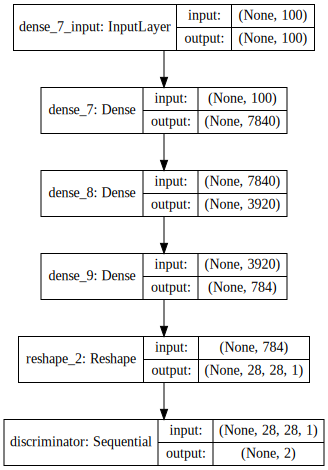

In [25]:
# Build stacked GAN model
# need new loss function here? Maximise entropy between two classes while
#discriminator is trying to reduce it?

GAN = Sequential()
GAN.add(generator)
GAN.add(discriminator)
GAN.compile(loss='binary_crossentropy', optimizer='adam')

GAN.summary()

draw_model_on_interactive_session(GAN)

In [26]:
losses = {'d':[], 'g':[], 'accuracy':[]}


def plot_loss(losses):   
    
    if ax.lines:
        ax.lines[0].set_data(list(range(len(losses["d"]))), losses["d"])
        ax.lines[1].set_data(list(range(len(losses["g"]))), losses["g"])
        ax.autoscale(True)
        
    else:        
        ax.plot(list(range(len(losses["d"]))), losses["d"])
        ax.plot(list(range(len(losses["g"]))), losses["g"])
        ax.autoscale()        
        
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

    
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)
    
    for i in range(generated_images.shape[0]):
        #plt.subplot(dim[0],dim[1],i+1)
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.show()
    image_fig.canvas.draw()


In [27]:
def pretrain_discriminator():
    make_trainable(discriminator,True)

    X, y = generate_discriminator_training_batch(30000)
    
    discriminator.fit(X, y, epochs=1, batch_size=250)


In [28]:
ntrain = 100

def perform_discriminator_training_steps(n_steps=1):
    make_trainable(discriminator,True)

    X, y = generate_discriminator_training_batch(ntrain)

    discriminator_history = 0

    for _ in range(n_steps):
        discriminator_history = discriminator.train_on_batch(X,y)

    losses['d'].append(discriminator_history)

    y_hat = discriminator.predict(X)

    accuracy, n_right, n_total = calculate_discriminator_accuracy(X, y)

    losses['accuracy'].append(accuracy)
    

In [29]:

def generate_discriminator_training_batch(batch_size):
    trainidx = random.sample(range(0,X_train.shape[0]), int(batch_size/2))
    XT = X_train[trainidx,:,:,:]

    noise_gen = np.random.uniform(0,1,size=[int(batch_size/2),100])

    generated_images = generator.predict(noise_gen)
    X = np.concatenate((XT, generated_images))
    n = XT.shape[0]
    y = np.zeros([2*n,2])
    y[:n,1] = 1
    y[n:,0] = 1

    X, y = shuffle(X, y)
    
    return X, y

In [30]:
def calculate_discriminator_accuracy(input_images, labels):
    
    def measure_accuracy(y, y_hat):
        # Measure accuracy of pre-trained discriminator network
        y_hat_idx = np.argmax(y_hat,axis=1)
        y_idx = np.argmax(y,axis=1)
        diff = y_idx-y_hat_idx
        n_total = y.shape[0]
        n_right = (diff==0).sum()
        accuracy = n_right*100.0/n_total
        return accuracy, n_right, n_total 

    
    y_hat = discriminator.predict(input_images)

    accuracy, n_right, n_total = measure_accuracy(labels, y_hat)
    return accuracy, n_right, n_total


In [31]:
 # train Generator-Discriminator stack on input noise to non-generated output class
def perform_generator_training_steps(n_steps=1):
    noise_tr = np.random.uniform(0,1,size=[ntrain, 100])
    y2 = np.zeros([ntrain,2])
    y2[:,1] = 1

    make_trainable(discriminator, False)

    #GAN.layers[2].layers[6].trainable
    #gan_history = GAN.fit(noise_tr, y2, epochs=10, shuffle=True )
    gan_history = 0
    for _ in range(n_steps):
        gan_history = GAN.train_on_batch(noise_tr, y2)
        
    losses['g'].append(gan_history)


In [ ]:
initialise_generator()

In [ ]:
pretrain_discriminator()

## Swap generator for CNN network

<IPython.core.display.Javascript object>


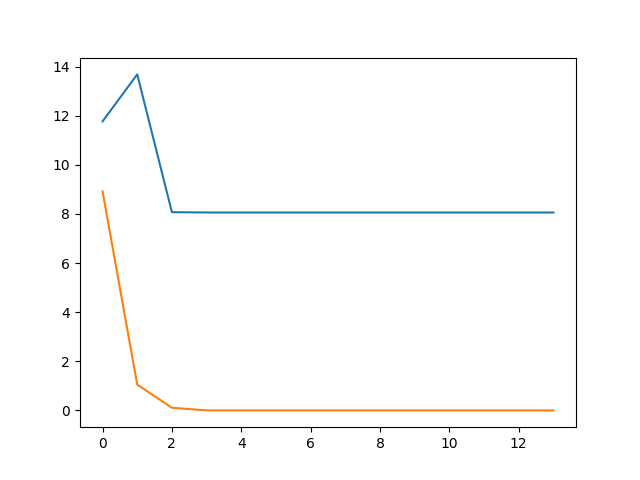

<IPython.core.display.Javascript object>


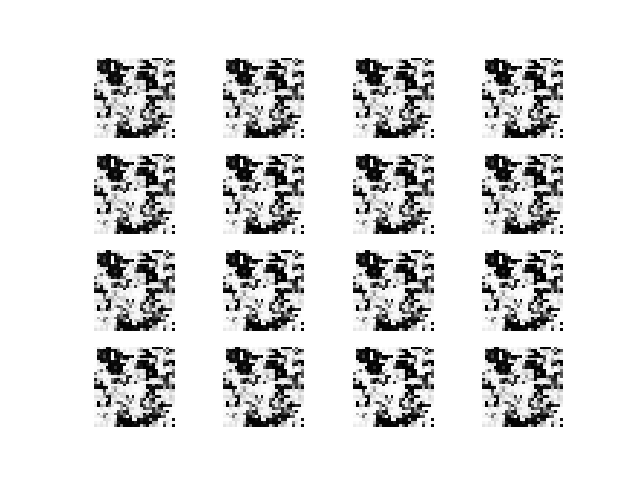

KeyboardInterrupt: 

In [32]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1)

image_fig, image_ax = plt.subplots(1, 1)

for _ in range(100):
    perform_discriminator_training_steps(1)
    perform_generator_training_steps(1)

    fig
    plot_loss(losses)
        
    image_fig
    plot_gen()

In [ ]:
GAN.predict(np.random.uniform(0,1,size=[1,100]))

In [ ]:
discriminator.predict(np.array([X_train[0]]))

In [ ]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        discriminator_history = discriminator.fit(X,y, epochs=1, shuffle=True)
        
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        gan_history = GAN.fit(noise_tr, y2, epochs=1, shuffle=True )
        
        print('discriminator: ', discriminator_history.history)
        print('gan: ', gan_history.history)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            #print(d_loss, ' ' , g_loss)
            plot_loss(losses)
            plot_gen()


In [ ]:
X_train.shape
im= generator.predict(np.random.uniform(0,1,size=[1,100]))
im.shape
print(np.argmax(discriminator.predict(np.array([im[0]]))))

print(np.argmax(discriminator.predict(np.array([X_train[0]]))))

In [ ]:
# Train for 6000 epochs at original learning rates
train_for_n(nb_epoch=6000, plt_frq=50,BATCH_SIZE=32)

In [ ]:
# Train for 2000 epochs at reduced learning rates
opt.lr.value = 1e-5
dopt.lr.value = 1e-4
train_for_n(nb_epoch=2000, plt_frq=500,BATCH_SIZE=32)


In [ ]:
opt.lr.value=1e-6
dopt.lr.value=1e-5
train_for_n(nb_epoch=2000, plt_frq=500,BATCH_SIZE=32)

In [ ]:
#plot_loss(losses)

# Plot some generated images from our GAN
plot_gen(25,(5,5),(12,12))

In [ ]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot real MNIST images for comparison
plot_real()

In [ ]:
import time

fig,ax = plt.subplots(1,1)
fig.show()


for i in range(5):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(np.random.random(size=(100,1)))
    else:
        x = np.linspace(0,1,100)
        y = np.random.random(size=(100,1))
        ax.plot(x, y)
    fig.canvas.draw()
    time.sleep(1)
    print(i)

In [ ]:
%matplotlib notebook
